In [2]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
import seaborn as sns
sns.set()
import gc
gc.collect()
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
from IPython.display import clear_output
#set_matplotlib_formats('retina')
#from tqdm import tqdm
#tqdm.pandas()
import numpy as np
from pyhive import presto
from datetime import datetime, timedelta
#from bson import ObjectId
from functools import reduce
from sklearn.cluster import KMeans
#from pymongo import MongoClient
import glob
import warnings
warnings.filterwarnings('ignore')
from datetime import date
import json
import re
#import dtale
#from h3 import h3
# import pandasql as ps

In [68]:
metabase_connection = presto.connect(
        #host='bi-trino-2.serving.data.production.internal',
        #host='bi-trino.serving.data.production.internal',
        #host='bi-presto.serving.data.production.internal',
        #host='prime-trino.serving.data.production.internal',
        #host="presto.processing.yoda.run",
        #host ="prime-trino-2.serving.data.production.internal",
        host = "processing-2.processing.data.production.internal",
        port=80,
        protocol='http',
        catalog ='hive',
        username='praveen.u@rapido.bike')

In [ ]:
#         count(distinct case when order_status='expired' and map_riders_count > 0 and Rank_1 = 1 THEN order_id END) as mapped_exp,
#         count(distinct case when order_status='expired' and map_riders_count = 0 and Rank_1 = 1 THEN order_id END) as Stockout,
#         count(distinct case when map_riders_count = 0 and Rank_1 = 1 then order_id end) as Unmapped_Orders,
#                    row_number() over (partition by order_id order by updated_epoch desc) as rank_1
#             cardinality(array_distinct(array_remove(split(replace(replace(replace(map_riders, '['), ']'), '"'), ','), ''))) as map_riders_count

#what kind of orders


In [ ]:
yyyymmdd,test/ctrl,time_period,marketplace_segment,lm_buckets,fulfilment_flag,gross_orders,APR,AOR,COBRA,Mapped_exp,OCARA,




In [ ]:
reports_inter. orb sample dataset



In [ ]:
yyyymmdd,time period,fm,lm,fulfilled/unfulfilled orders, due to ocara,cobra,ME,unmapped EXP, 

In [ ]:
#based on fm,lm,amount,marketplace seg, test vs control - fulfilled/unfulfilled - APR increased, AOR remain same

In [ ]:
in the unfulfilled orders - 

In [72]:
per_Days_data=pd.DataFrame()

for i in pd.date_range('20230704','20230714'):

    query="""
        with order_filtering as 
        ( 
        select distinct yyyymmdd,order_id ,city_name, pickup_location_hex_8,
                CASE 
                    WHEN substr(quarter_hour,1,2) IN ('08','09','10','11') THEN 'morning_peak'
                    WHEN substr(quarter_hour,1,2) IN ('12','13','14','15','16') THEN 'afternoon'
                    WHEN substr(quarter_hour,1,2) IN ('17','18','19','20','21') THEN 'evening_peak'
                    WHEN substr(quarter_hour,1,2) IN ('00','01','02','03','04','05','06','07') THEN 'rest_morning'        
                    ELSE 'rest_evening' END AS time_period, order_status,quarter_hour,

                case when distance_final_distance<=3 then '0_3km'
                when distance_final_distance<=5 then '3_5km'
                when distance_final_distance<=8 then '5_8km'
                when distance_final_distance<=12 then '8_12km'
                when distance_final_distance>12 then '12km_above'
                end as lm_bucket,

                case when order_status != 'dropped' then 'unfulfilled_order'
                else 'fulfilled_order' end as fulfilment_flag

        from 
            orders.order_logs_snapshot
            --where yyyymmdd = '20230625' 
            where yyyymmdd = cast({dt} as varchar)
            and service_obj_service_name = 'Auto'
            and lower(trim(city_name)) in ('pune') 
    ),
    rider_pings as

        (
            select yyyymmdd,data_orderid,
                count(distinct case when event_type = 'rider_busy' then unique_ping_level_id end) as riderBusy_pings,
                count(distinct case when event_type = 'rider_rejected' then unique_ping_level_id end) as riderreject_Pings,
                count(distinct case when event_type = 'rider_accepted' then unique_ping_level_id end) as accepted_pings,
                count(distinct case when event_type = 'order_already_accepted' then unique_ping_level_id end) as already_accepted_pings,
                count(distinct case when event_type = 'rider_accept_failed' then unique_ping_level_id end) as rider_accept_failure_pings,        
                count(distinct case when event_type = 'rider_acknowledged' then unique_ping_level_id end) as rider_ack_pings
            from
            (
                   select yyyymmdd,quarter_hour,hh,epoch,data_propagationBatchId,data_riderId,data_orderid,
                    pickup_location_hex_8,event_type,unique_ping_level_id

                    from
                    (
                        select propagation_batch_id as data_propagationBatchId,rider_id as data_riderId,order_id as data_orderid,yyyymmdd,quarter_hour,hh,
                        concat(propagation_batch_id,rider_id,order_id) as unique_ping_level_id,pickup_location_hex_8,
                        updated_epoch as epoch,event_type
                        from orders.dispatch_propagation_immutable
                        where yyyymmdd = cast({dt} as varchar)
                        --where yyyymmdd = '20230625' --and yyyymmdd <= '20230707'
                        and order_id in (select distinct order_id from order_filtering)
                        and event_type in ('rider_acknowledged')
                        and propagation_type in ('multicast')

                        union all

                        select data_propagationBatchId,data_riderId,data_orderid,yyyymmdd,quarter_hour,hh,
                        concat(data_propagationBatchId,data_riderId,data_orderid) as unique_ping_level_id,pickup_location_hex_8,
                        updated_epoch as epoch,event_type


                        from(
                                select event_type as eventtype,propagation_batch_id as data_propagationBatchId,rider_id as data_riderId,order_id as data_orderid,yyyymmdd,quarter_hour,hh,
                                updated_epoch,event_type,pickup_location_hex_8,drop_location_hex_8,epoch,
                                row_number() over(partition by propagation_batch_id,rider_id,order_id order by epoch desc) as row

                                from orders.dispatch_propagation_immutable
                                    where yyyymmdd = cast({dt} as varchar)
                                    --where yyyymmdd = '20230625' --and yyyymmdd <= '20230707'
                                    and order_id in (select distinct order_id from order_filtering)
                                    and propagation_type in ('multicast')
                                    and event_type in ('rider_busy','order_already_accepted','rider_accept_failed','rider_rejected','rider_accepted','rider_ineligible','rider_unreachable')
                            ) base

                            where row =1
                        )
                    )

                    group by 1,2
        ),

        immutabl_raw as (

                           select yyyymmdd, city_name,order_id,captain_id,event_type,order_status,updated_epoch,accept_to_pickup_distance

                            from orders.order_logs_immutable
                                where yyyymmdd = cast({dt} as varchar)
                                and lower(trim(city_name)) in ('pune')
                                and service_obj_service_name in ('Auto')
                                and order_id in (select distinct order_id from order_filtering)
                                and (spd_fraud_flag = false OR spd_fraud_flag IS NULL)

                 ),


       immutable_v2   as 

                ( 
                    select yyyymmdd, city_name,order_id,
                    count(distinct order_id) as gross_orders,
                    count(distinct case when  net_order='dropped' then order_id end) as net_order,                 
                    count(distinct case when  accepted_order='accepted' then order_id end) as accepted_order,  
                    count(distinct case when order_level_end_state='COBRA' then order_id end) as COBRA,
                    count(distinct case when order_level_end_state='Mapped_expiry' then order_id end) as Mapped_expiry,
                    count(distinct case when order_level_end_state='OCARA' then order_id end) as OCARA

                    from
                    (
                    select yyyymmdd, city_name,order_id,
                        case when contains(event_type_agg, 'accepted') then 'accepted' end as accepted_order,
                        case when contains(order_status_agg, 'dropped') then 'dropped' end as net_order,                
                        case 
                            when contains(event_type_agg, 'accepted') = false and  contains(order_status_agg, 'customerCancelled') =true then 'COBRA'
                            when  contains(order_status_agg, 'expired') = true and contains(event_type_agg, 'accepted') = false then 'Mapped_expiry'
                            when contains(event_type_agg, 'accepted') = true and  (contains(event_type_agg, 'rider_cancelled') =false and contains(event_type_agg, 'customer_cancelled') =true)  then 'OCARA'
                            when contains(event_type_agg, 'accepted') = true and  (contains(event_type_agg, 'rider_cancelled') =true and contains(event_type_agg, 'customer_cancelled') =false)  then 'OCARA'                                
                            else 'others'
                        end as order_level_end_state

                    from
                    (
                        select * 
                        from
                        (
                            select yyyymmdd, city_name,order_id,order_status,
                            array_agg(event_type) over (partition by order_id) as event_type_agg,
                            array_agg(order_status) over (partition by order_id) as order_status_agg,
                            row_number() over(partition by order_id) as row_num

                            from immutabl_raw

                        )
                        where row_num=1 
                    )
                    )
                    group by 1,2,3 

                    ),
                    
  mr_data as     (
        
        select yyyymmdd,order_id,
        count(distinct map_riders_lst) as total_map_riders,
        count(distinct case when fm<=500 then map_riders_lst end) as MR_within_500m,
        count(distinct case when fm>500 and fm<=1000 then map_riders_lst end) as MR_500m_to_1km,        
        count(distinct case when fm>1000 and fm<=1500 then map_riders_lst end) as MR_1km_to_limit_km,
        count(distinct case when fm>1500 then map_riders_lst end) as MR_more_than_limit_km,

        count(distinct case when performance='UHP' then map_riders_lst end) as MR_UHP_caps,
        count(distinct case when performance='HP' then map_riders_lst end) as MR_HP_caps,
        count(distinct case when performance='MP' then map_riders_lst end) as MR_MP_caps,
        count(distinct case when performance='LP' then map_riders_lst end) as MR_LP_caps,

        count(distinct case when contains(event_type_agg, 'accepted') and fm<=500 then order_id end) accp_within_500m_fm,
        count(distinct case when contains(event_type_agg, 'accepted') and fm<=1000 then order_id end) accp_within_500m_to_1km_fm,
        count(distinct case when contains(event_type_agg, 'accepted') and fm<=1500 then order_id end) accp_within_1km_to_limit_km_fm, 
        count(distinct case when contains(event_type_agg, 'accepted') and fm>1500 then order_id end) accp_with_more_than_limit_km_fm        
        
        from
        (
            select tt1.yyyymmdd,tt1.order_id,map_riders_lst,fm,performance,event_type_agg
            from
            (
              select distinct yyyymmdd,order_id,map_riders_lst
                
              from 
                (
                    select yyyymmdd,order_id,
                    cast(json_parse(map_riders) as array(varchar)) as map_riders
                    from orders.order_logs_immutable
                    where 
                    yyyymmdd = cast({dt} as varchar)
                    and city_name in ('Pune')  --,'Pune'
                    and service_obj_service_name in ('Auto')

                ) 
                cross join unnest(map_riders) as t(map_riders_lst)
                
            )as tt1

            left join(
                      
                    select distinct yyyymmdd,order_id,captain_id,
                    array_agg(event_type) over (partition by order_id,captain_id) as event_type_agg
                    
                    from orders.order_logs_immutable
                    where 
                    yyyymmdd = cast({dt} as varchar)
                    and city_name in ('Pune') --,'Pune'
                    and service_obj_service_name in ('Auto')

                    ) nt1
                    
                    on tt1.yyyymmdd=nt1.yyyymmdd and tt1.order_id = nt1.order_id and tt1.map_riders_lst = nt1.captain_id
                    
            
            left join (

                    select yyyymmdd,captain_id,order_id,      
                            avg(captains_firstmiledistance) as fm
                            from g2n.flattened_captains
                            where yyyymmdd =cast({dt} as varchar)
                            and service_detail_id in ('61769b50d21e19252c6f60e8') --,'5ef2bc5b85846b775f97d170'
                        group by 1,2,3 
                    ) as tt2

                    on tt1.map_riders_lst = tt2.captain_id and tt1.order_id = tt2.order_id and tt1.yyyymmdd=tt2.yyyymmdd
            left join (

                        select captain_id,performance 
                        from hive.datasets_internal.captain_auto_pc_segments_v2 
                        where yyyymmdd = cast({dt} as varchar)
                    ) tt3
                    on tt1.map_riders_lst = tt3.captain_id
        )
        group by 1,2 
        
        
        )
                    

            select yyyymmdd,city_name,test_ctrl,segment,time_period,lm_bucket,fulfilment_flag,

                sum(gross_orders) as gross_orders,
                sum(net_order) as net_orders,
                sum(accepted_order) as accepted_orders,
                sum(COBRA) as COBRA,
                sum(Mapped_expiry) as Mapped_expiry,
                sum(OCARA) as OCARA,
                sum(riderBusy_pings) as rider_busy_pings,
                sum(riderreject_Pings) as rider_rejeted_pings,
                sum(accepted_pings) as accepted_pings,
                sum(accepted_pings+rider_accept_failure_pings) as all_accepted_pings,
                sum(already_accepted_pings) as already_accepted_pings,
                sum(rider_ack_pings) as total_pings,

                sum(total_map_riders) as total_map_riders,
                avg(total_map_riders) as avg_map_riders,

                sum(MR_within_500m) as total_MR_within_500m,
                avg(MR_within_500m) as avg_MR_within_500m,

                sum(MR_500m_to_1km) as total_MR_500m_to_1km,
                avg(MR_500m_to_1km) as avg_MR_500m_to_1km,

                sum(MR_1km_to_limit_km) as total_MR_1km_to_limit_km,
                avg(MR_1km_to_limit_km) as avg_MR_1km_to_limit_km,    

                sum(MR_more_than_limit_km) as total_MR_more_than_limit_km,
                avg(MR_more_than_limit_km) as avg_MR_more_than_limit_km,

                sum(MR_UHP_caps) as total_MR_UHP_caps,
                avg(MR_UHP_caps) as avg_MR_UHP_caps,

                sum(MR_HP_caps) as total_MR_HP_caps,
                avg(MR_HP_caps) as avg_MR_HP_caps,    

                sum(MR_MP_caps) as total_MR_MP_caps,
                avg(MR_MP_caps) as avg_MR_MP_caps,

                sum(MR_LP_caps) as total_MR_LP_caps,
                avg(MR_LP_caps) as avg_MR_LP_caps,

                sum(accp_within_500m_fm) as total_accp_within_500m_fm,
                avg(accp_within_500m_fm) as avg_accp_within_500m_fm,

                sum(accp_within_500m_to_1km_fm) as total_accp_within_500m_to_1km_fm,
                avg(accp_within_500m_to_1km_fm) as avg_accp_within_500m_to_1km_fm,

                sum(accp_within_1km_to_limit_km_fm) as total_accp_within_1_limit_km_fm,
                avg(accp_within_1km_to_limit_km_fm) as avg_accp_within_1_limit_km_fm,

                sum(accp_with_more_than_limit_km_fm) as total_accp_with_more_than_limit_km_fm,
                avg(accp_with_more_than_limit_km_fm) as avg_accp_with_more_than_limit_km_fm

            from
            (
            select a.yyyymmdd,a.order_id ,a.city_name,test_ctrl,segment,pickup_location_hex_8,time_period,lm_bucket,fulfilment_flag,
            riderBusy_pings,riderreject_Pings,accepted_pings,already_accepted_pings,rider_accept_failure_pings,rider_ack_pings,
            gross_orders,net_order,accepted_order,COBRA,Mapped_expiry,OCARA,
            
            total_map_riders,MR_within_500m,MR_500m_to_1km,MR_1km_to_limit_km,MR_more_than_limit_km,
            MR_UHP_caps,MR_HP_caps,MR_MP_caps,MR_LP_caps,
            accp_within_500m_fm,accp_within_500m_to_1km_fm,accp_within_1km_to_limit_km_fm,
            accp_with_more_than_limit_km_fm

            from  order_filtering as a 
            left join rider_pings as b
            on a.yyyymmdd =b.yyyymmdd and a.order_id=b.data_orderid

            left join immutable_v2 as c
            on a.yyyymmdd=c.yyyymmdd and a.order_id =c.order_id
            
            left join mr_data as d 
            on a.yyyymmdd=d.yyyymmdd and a.order_id =d.order_id
            
            
            left join (
                        select city_name,test_ctrl, hex_id ,time_bucket
                        from experiments_internal.auto_apr_fm_reduction_exp_230704 
                        where city_name in ('Pune','Hyderabad')

                     ) exp_dt
                     on a.pickup_location_hex_8 = exp_dt.hex_id and a.time_period = exp_dt.time_bucket

        left join           
                   (
                   select city,service,uid,segment
                    from experiments_internal.holdout_areas_v2
                    where service='Auto' and city in ('Hyderabad','Pune')

                   ) as v1 
                   on concat(a.pickup_location_hex_8,'-',a.time_period) = v1.uid



              where case when a.yyyymmdd >='20230710' and concat(a.pickup_location_hex_8,a.time_period) 
                   in ('8860a25829fffffevening_peak','8860a259c1fffffevening_peak',
                        '8860a2583bfffffevening_peak','8860a2598dfffffevening_peak',
                        '8860a259cdfffffevening_peak','8860a25825fffffevening_peak',
                        '8860a259d5fffffevening_peak','8860a25839fffffevening_peak',
                        '8860a25821fffffevening_peak','8860a25989fffffevening_peak',
                        '8860a2583dfffffevening_peak','8860a259e1fffffevening_peak',
                        '8860a259ddfffffevening_peak','8860a25833fffffevening_peak',
                        '8860a25827fffffevening_peak','8860a259c7fffffevening_peak',
                        '8860a259c9fffffevening_peak','8860a25835fffffevening_peak',
                        '8860a25917fffffevening_peak','8860a259d1fffffevening_peak',
                        '8860a2591bfffffevening_peak','8860a259e3fffffevening_peak',
                        '8860a25831fffffevening_peak','8860a25913fffffevening_peak',
                        '8860a25807fffffevening_peak','8860a259e9fffffevening_peak',
                        '8860a2582bfffffevening_peak','8860a25823fffffevening_peak',
                        '8860a25837fffffevening_peak','8860a259edfffffevening_peak',
                        '8860a259c3fffffevening_peak','8860a25911fffffevening_peak',
                        '8860a259cbfffffevening_peak','8860a259ebfffffevening_peak',
                        '8860a25919fffffevening_peak','8860a259d9fffffevening_peak',
                        '8860a259c5fffffevening_peak','8860b19693fffffevening_peak','8860a24b45fffffevening_peak','8860b194d9fffffevening_peak',
                        '8860a24b47fffffevening_peak','8860a24b01fffffevening_peak','8860b19695fffffevening_peak','8860b19697fffffevening_peak',
                        '8860a24b21fffffevening_peak','8860a24b2bfffffevening_peak','8860a24b63fffffevening_peak','8860b194dbfffffevening_peak',
                        '8860a24b29fffffevening_peak','8860a24b09fffffevening_peak','8860a24b69fffffevening_peak','8860a24b23fffffevening_peak',
                        '8860a24b05fffffevening_peak','8860b196bbfffffevening_peak','8860a24b2dfffffevening_peak','8860a24b65fffffevening_peak',
                        '8860b19691fffffevening_peak','8860a24b67fffffevening_peak','8860a24b6dfffffevening_peak','8860b196b3fffffevening_peak',
                        '8860b196b7fffffevening_peak','8860a24b0dfffffevening_peak','8860b196b1fffffevening_peak','8860a24b6bfffffevening_peak',
                        '8860a24b61fffffevening_peak','8860a24a23fffffmorning_peak','8860a24a05fffffmorning_peak','8860a24b13fffffmorning_peak',
                        '8860a24845fffffmorning_peak','8860a24a2bfffffmorning_peak','8860a24a0dfffffmorning_peak','8860a24b55fffffmorning_peak',
                        '8860a24b11fffffmorning_peak','8860a24a6dfffffmorning_peak','8860a24b0bfffffmorning_peak','8860a259b3fffffmorning_peak',
                        '8860a24b03fffffmorning_peak','8860a259b7fffffmorning_peak','8860a24841fffffmorning_peak','8860a24a27fffffmorning_peak',
                        '8860a24a21fffffmorning_peak','8860a24849fffffmorning_peak','8860a24a63fffffmorning_peak','8860a24b15fffffmorning_peak',
                        '8860a24a69fffffmorning_peak','8860a24b1dfffffmorning_peak','8860a24b51fffffmorning_peak','8860a24a61fffffmorning_peak',
                        '8860a24a67fffffmorning_peak','8860a25993fffffmorning_peak','8860a24869fffffmorning_peak','8860a24b59fffffmorning_peak',
                        '8860a24a2dfffffmorning_peak','8860a24a6bfffffmorning_peak','8860a24a25fffffmorning_peak','8860a24b1bfffffmorning_peak',
                        '8860a24b19fffffmorning_peak','8860a2484dfffffmorning_peak','8860a24a29fffffmorning_peak','8860a24b57fffffmorning_peak',
                        '8860a24b5dfffffmorning_peak','8860a24b53fffffmorning_peak','8860a24b17fffffmorning_peak','8860a24b5bfffffmorning_peak',
                        '8860a24a65fffffmorning_peak'

                        ) then 1 else 0 end =0

                    and 
                       concat(a.time_period,a.pickup_location_hex_8) not in 
                        ('evening_peak8860b19693fffff','evening_peak8860a24b45fffff','evening_peak8860b194d9fffff',
                        'evening_peak8860a24b47fffff','evening_peak8860a24b01fffff','evening_peak8860b19695fffff',
                        'evening_peak8860b19697fffff','evening_peak8860a24b21fffff','evening_peak8860a24b2bfffff',
                        'evening_peak8860a24b63fffff','evening_peak8860b194dbfffff','evening_peak8860a24b29fffff',
                        'evening_peak8860a24b09fffff','evening_peak8860a24b69fffff','evening_peak8860a24b23fffff',
                        'evening_peak8860a24b05fffff','evening_peak8860b196bbfffff','evening_peak8860a24b2dfffff',
                        'evening_peak8860a24b65fffff','evening_peak8860b19691fffff','evening_peak8860a24b67fffff',
                        'evening_peak8860a24b6dfffff','evening_peak8860b196b3fffff','evening_peak8860b196b7fffff',
                        'evening_peak8860a24b0dfffff','evening_peak8860b196b1fffff','evening_peak8860a24b6bfffff','evening_peak8860a24b61fffff'
                        )

                )
            group by 1,2,3,4,5,6,7

            """.format(dt=i.strftime('%Y%m%d'))
      
    df_test=pd.read_sql_query(query, metabase_connection)
    
    print(i)
    
    per_Days_data=per_Days_data.append(df_test)

2023-07-04 00:00:00
2023-07-05 00:00:00
2023-07-06 00:00:00
2023-07-07 00:00:00
2023-07-08 00:00:00
2023-07-09 00:00:00
2023-07-10 00:00:00
2023-07-11 00:00:00
2023-07-12 00:00:00
2023-07-13 00:00:00
2023-07-14 00:00:00


In [73]:
per_Days_data.to_clipboard()

In [44]:
dt#.groupby(['yyyymmdd','fulfilment_flag'])[['gross_orders','net_orders','accepted_orders','OCARA','COBRA','Mapped_expiry']].sum()

,yyyymmdd,city_name,test_ctrl,segment,time_period,lm_bucket,fulfilment_flag,gross_orders,net_orders,accepted_orders,...,total_MR_LP_caps,avg_MR_LP_caps,total_accp_within_500m_fm,avg_accp_within_500m_fm,total_accp_within_500m_to_1km_fm,avg_accp_within_500m_to_1km_fm,total_accp_within_1_limit_km_fm,avg_accp_within_1_limit_km_fm,total_accp_with_more_than_limit_km_fm,avg_accp_with_more_than_limit_km_fm
0,20230704,Hyderabad,ctrl_3,balanced-high,evening_peak,0_3km,unfulfilled_order,719,0,87,...,5561.0,7.788515,18.0,0.025210,47.0,0.065826,62.0,0.086835,28.0,0.039216
1,20230704,Hyderabad,test_2,in-low,rest_evening,8_12km,unfulfilled_order,63,0,31,...,370.0,6.379310,7.0,0.120690,20.0,0.344828,30.0,0.517241,4.0,0.068966
2,20230704,Hyderabad,ctrl_3,in-high,rest_evening,5_8km,fulfilled_order,50,50,50,...,734.0,14.680000,9.0,0.180000,19.0,0.380000,37.0,0.740000,15.0,0.300000
3,20230704,Hyderabad,ctrl_4,out-high,evening_peak,3_5km,unfulfilled_order,499,0,93,...,7781.0,15.593186,9.0,0.018036,31.0,0.062124,57.0,0.114228,45.0,0.090180
4,20230704,Hyderabad,None,in-high,afternoon,5_8km,fulfilled_order,115,115,115,...,3881.0,33.747826,22.0,0.191304,70.0,0.608696,101.0,0.878261,20.0,0.173913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,20230704,Hyderabad,test_2,out-high,afternoon,5_8km,unfulfilled_order,152,0,60,...,1954.0,12.855263,7.0,0.046053,26.0,0.171053,53.0,0.348684,10.0,0.065789
1384,20230704,Hyderabad,ctrl_4,in-low,rest_evening,12km_above,unfulfilled_order,55,0,48,...,1119.0,20.345455,14.0,0.254545,23.0,0.418182,38.0,0.690909,17.0,0.309091
1385,20230704,Hyderabad,ctrl_4,balanced-low,evening_peak,8_12km,fulfilled_order,43,43,43,...,854.0,19.860465,8.0,0.186047,23.0,0.534884,31.0,0.720930,15.0,0.348837
1386,20230704,Hyderabad,None,out-low,evening_peak,0_3km,fulfilled_order,6,6,6,...,28.0,4.666667,1.0,0.166667,3.0,0.500000,4.0,0.666667,2.0,0.333333


In [33]:
35957+92386+47419+26154

201916

In [36]:
dt

,yyyymmdd,city_name,test_ctrl,segment,time_period,lm_bucket,fulfilment_flag,gross_orders,net_orders,accepted_orders,...,total_MR_LP_caps,avg_MR_LP_caps,total_accp_within_500m_fm,avg_accp_within_500m_fm,total_accp_within_500m_to_1km_fm,avg_accp_within_500m_to_1km_fm,total_accp_within_1_limit_km_fm,avg_accp_within_1_limit_km_fm,total_accp_with_more_than_limit_km_fm,avg_accp_with_more_than_limit_km_fm
0,20230704,Hyderabad,ctrl_3,balanced-high,evening_peak,0_3km,unfulfilled_order,719,0,87,...,5561.0,7.788515,18.0,0.025210,47.0,0.065826,62.0,0.086835,28.0,0.039216
1,20230704,Hyderabad,test_2,in-low,rest_evening,8_12km,unfulfilled_order,63,0,31,...,370.0,6.379310,7.0,0.120690,20.0,0.344828,30.0,0.517241,4.0,0.068966
2,20230704,Hyderabad,ctrl_3,in-high,rest_evening,5_8km,fulfilled_order,50,50,50,...,734.0,14.680000,9.0,0.180000,19.0,0.380000,37.0,0.740000,15.0,0.300000
3,20230704,Hyderabad,ctrl_4,out-high,evening_peak,3_5km,unfulfilled_order,499,0,93,...,7781.0,15.593186,9.0,0.018036,31.0,0.062124,57.0,0.114228,45.0,0.090180
4,20230704,Hyderabad,None,in-high,afternoon,5_8km,fulfilled_order,115,115,115,...,3881.0,33.747826,22.0,0.191304,70.0,0.608696,101.0,0.878261,20.0,0.173913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383,20230704,Hyderabad,test_2,out-high,afternoon,5_8km,unfulfilled_order,152,0,60,...,1954.0,12.855263,7.0,0.046053,26.0,0.171053,53.0,0.348684,10.0,0.065789
1384,20230704,Hyderabad,ctrl_4,in-low,rest_evening,12km_above,unfulfilled_order,55,0,48,...,1119.0,20.345455,14.0,0.254545,23.0,0.418182,38.0,0.690909,17.0,0.309091
1385,20230704,Hyderabad,ctrl_4,balanced-low,evening_peak,8_12km,fulfilled_order,43,43,43,...,854.0,19.860465,8.0,0.186047,23.0,0.534884,31.0,0.720930,15.0,0.348837
1386,20230704,Hyderabad,None,out-low,evening_peak,0_3km,fulfilled_order,6,6,6,...,28.0,4.666667,1.0,0.166667,3.0,0.500000,4.0,0.666667,2.0,0.333333


In [42]:
from datetime import datetime
yyyymmdd = pd.date_range(start='2023-07-10', end='2023-07-10').strftime('%Y%m%d').to_list()

df1 = pd.DataFrame()
for i in range(len(yyyymmdd)):
    dt = yyyymmdd[i]
    query1 = f"""
with order_filtering as 
(
    select distinct yyyymmdd,order_id ,city_name, pickup_location_hex_8,drop_location_hex_8,
            CASE 
                WHEN substr(quarter_hour,1,2) IN ('08','09','10','11') THEN 'morning_peak'
                WHEN substr(quarter_hour,1,2) IN ('12','13','14','15','16') THEN 'afternoon'
                WHEN substr(quarter_hour,1,2) IN ('17','18','19','20','21') THEN 'evening_peak'
                WHEN substr(quarter_hour,1,2) IN ('00','01','02','03','04','05','06','07') THEN 'rest_morning'        
                ELSE 'rest_evening' END AS time_period, order_status,quarter_hour,
            
            case when order_status != 'dropped' then 'unfulfilled_order'
            else 'fulfilled_order' end as fulfilment_flag

    from 
        orders.order_logs_snapshot
        -- where yyyymmdd = '20230625' 
        where yyyymmdd = cast({dt} as varchar)
        and service_obj_service_name = 'Auto'
        and lower(trim(city_name)) in ('hyderabad') 
)

, rider_pings as (
   select *
   from (
   select yyyymmdd,data_propagationBatchId,data_riderId,data_orderid,
    eventtype as event_type,
    unique_ping_level_id,unique_id_order_level_id
    
    from
    (

        select data_propagationBatchId,data_riderId,data_orderid,yyyymmdd,
        concat(data_propagationBatchId,data_riderId,data_orderid) as unique_ping_level_id,
        concat(data_orderid,data_riderId) as unique_id_order_level_id,updated_epoch as epoch,eventtype

        
        from(
                select eventtype,data_propagationBatchId,data_riderId,data_orderid,yyyymmdd,
                updated_epoch,
                
                row_number() over(partition by data_propagationBatchId,data_riderId,data_orderid order by updated_epoch desc) as row

                from raw.kafka_dispatch_propagation_immutable
                    -- where yyyymmdd = '20230625' 
                    where yyyymmdd = cast({dt} as varchar)
                    and data_orderid in (select distinct order_id from order_filtering)
                    and data_propagationtype in ('multicast')
                    -- and eventtype in ('rider_busy','order_already_accepted','rider_accept_failed','rider_rejected','rider_accepted','rider_ineligible','rider_unreachable')
                    and eventtype in ('rider_accepted','rider_rejected','rider_busy')
            ) base
            
            where row =1
        )
    )

)

, immutable as (

    select order_id,captain_id,
        case 
            when contains(order_status_agg, 'dropped') = true and (spd_fraud_flag = false OR spd_fraud_flag IS NULL) then 'Net_Orders'
            when contains(event_type_agg, 'accepted') = true and ( contains(order_status_agg, 'customerCancelled') =true and contains(event_type_agg, 'rider_cancelled') =false) then 'OCARA_CC'
            when contains(event_type_agg, 'accepted') = true and  (contains(event_type_agg, 'rider_cancelled') =true  and  contains(order_status_agg, 'customerCancelled') =false)then 'OCARA_RC'
            else 'others'
        end as order_level_end_state_2,

        accept_to_pickup_distance
    from
        (
            select yyyymmdd, city_name,order_id,captain_id,accept_to_pickup_distance,spd_fraud_flag,
            array_agg(event_type) over (partition by order_id,captain_id) as event_type_agg,
            array_agg(order_status) over (partition by order_id,captain_id) as order_status_agg,
            row_number() over(partition by order_id,captain_id) as row_num
            
            from 
            (
             select yyyymmdd, city_name,order_id,captain_id,event_type,
             order_status,updated_epoch,accept_to_pickup_distance,spd_fraud_flag,updated_epoch


            
            from orders.order_logs_immutable
                -- where yyyymmdd = '20230625' 
                where yyyymmdd = cast({dt} as varchar)
                and lower(trim(city_name)) in ('hyderabad')
                and service_obj_service_name in ('Auto')
                and order_id in (select distinct order_id from order_filtering)

            )
            
        )
        where row_num=1 

)

 , prioritized_caps as (
        select
                yyyymmdd,
                city_name,
                order_id,
                captain_id,
                CASE 
                    WHEN substr(hh,1,2) IN ('08','09','10','11') THEN 'morning_peak'
                    WHEN substr(hh,1,2) IN ('12','13','14','15','16') THEN 'afternoon'
                    WHEN substr(hh,1,2) IN ('17','18','19','20','21') THEN 'evening_peak'
                    WHEN substr(hh,1,2) IN ('00','01','02','03','04','05','06','07') THEN 'rest_morning'        
                    ELSE 'rest_evening' END AS time_period, 
                avg(captains_firstmiledistance) as pri_fm,
                avg(last_mile_distance) as pri_lm

        from
                g2n.flattened_captains
            where yyyymmdd = cast({dt} as varchar)
            and service_detail_id='5ef2bc5b85846b775f97d170'
            
        group by 1,2,3,4,5
)

, auto_segments as 
(
    select captain_id, yyyymmdd, performance_segment, consistency
    from datasets_internal.captain_auto_pc_segments_v1
    where yyyymmdd = cast({dt} as varchar)
    -- where yyyymmdd = '20230625'
    and lower(trim(city_name)) in ('hyderabad')
    group by 1,2,3,4
)


select *,
case when fm<=1500 then '0_1.5km'
     when fm<=2500 then '1.5_2.5km'
     when fm<=3500 then '2.5_3.5km'
     when fm<=4500 then '3.5_4.5km'     
     when fm>4500 then '4.5km_above' 
     end as fm_buckets,
     case when lm<=3000 then '0_3km'
          when lm<=5000 then '3_5km'
          when lm<=8000 then '5_8km'
          when lm<=12000 then '8_12km'
        when lm>12000 then '12km_above'
        end as lm_bucket
from

(
    select distinct a.yyyymmdd,e.fulfilment_flag,a.data_orderid,a.data_riderid,a.event_type,a.unique_ping_level_id,
    cast(b.pri_fm as real) as lm,
    cast(b.pri_fm as real) as fm,
    d.order_level_end_state_2,
    e.city_name,
    e.time_period,
    f.performance_segment, 
    f.consistency


    from rider_pings a

    left join prioritized_caps b on a.data_orderid = b.order_id and a.data_riderid = b.captain_id

    left join immutable d on a.data_orderid = d.order_id and a.data_riderid = d.captain_id
    left join order_filtering e on a.data_orderid = e.order_id
    left join auto_segments f on a.data_riderid = f.captain_id
)
    """
    print(dt)
    t1 = pd.read_sql_query(query1, metabase_connection)
    df1 = pd.concat([t1, df1], axis=0).reset_index(drop=True)

20230710


In [43]:
df1.head(5)

,yyyymmdd,fulfilment_flag,data_orderid,data_riderid,event_type,unique_ping_level_id,lm,fm,order_level_end_state_2,city_name,time_period,performance_segment,consistency,fm_buckets,lm_bucket
0,20230710,unfulfilled_order,64ab8f711e9978677e562354,647dacce48732195c2413b3d,rider_busy,c7a6f614-3e36-44cb-8908-3f03b0af69a7647dacce48...,2431.10,2431.10,others,Hyderabad,morning_peak,MP,intra,1.5_2.5km,0_3km
1,20230710,unfulfilled_order,64ab1862f902dc1b9701098f,62c422122e60b0d3c1c62e49,rider_busy,081e41c0-0d89-4e13-b0a6-84bdf17512b562c422122e...,1649.95,1649.95,others,Hyderabad,rest_morning,LP,Daily,1.5_2.5km,0_3km
2,20230710,unfulfilled_order,64ab14a8f902dc1b970106da,62908b3d44357940d2ee157e,rider_rejected,552a0952-6aae-423e-8751-6be67531eeaa62908b3d44...,1802.10,1802.10,others,Hyderabad,rest_morning,HP,Daily,1.5_2.5km,0_3km
3,20230710,unfulfilled_order,64ac196584ea8a31e44cd3a7,623eabfb85046b7bdea1c84b,rider_busy,f9b985a0-b3dc-48c0-8107-50e08fd08416623eabfb85...,924.95,924.95,others,Hyderabad,evening_peak,MP,intra,0_1.5km,0_3km
4,20230710,unfulfilled_order,64ac1530d4b70444de8e4071,5f5353ebf536d067ce54f0e0,rider_rejected,203ff2f1-dd3a-4a5d-83f7-aa709e4d33c65f5353ebf5...,1636.30,1636.30,others,Hyderabad,evening_peak,LP,inter,1.5_2.5km,0_3km


In [44]:
df1.groupby(['fulfilment_flag'])[['data_orderid']].nunique().to_clipboard()

In [45]:
df1.groupby(['fulfilment_flag','lm_bucket'])[['data_orderid']].nunique().to_clipboard()

In [30]:
#df1.groupby(['fulfilment_flag','performance_segment'])[['data_riderid']].nunique()

In [32]:
a1=df1.groupby(['fulfilment_flag','performance_segment'],as_index=False)[['data_riderid']].nunique()

In [34]:
a1.to_clipboard()

In [46]:
df1[df1.fulfilment_flag=='unfulfilled_order'].groupby(['fm_buckets','lm_bucket','fulfilment_flag'])[['unique_ping_level_id']].nunique().to_clipboard()



In [40]:
df1[df1.fulfilment_flag=='unfulfilled_order'].groupby(['fm_buckets','lm_bucket','fulfilment_flag','event_type'])[['unique_ping_level_id']].nunique().to_clipboard()



In [11]:
df_orb = df_orb.drop(['unique_ping_level_id','eta'], axis=1)

In [26]:
print(df1[df1.event_type == 'rider_accepted'].groupby('order_level_end_state_2').size(),'-',sum(df1[df1.event_type == 'rider_accepted'].order_level_end_state_2.isnull()))

order_level_end_state_2
Net_Orders    20684
OCARA_CC       8699
OCARA_RC       4490
others          164
dtype: int64 - 66682


# Univariate

### Bangalore

event_type           rider_accepted  rider_busy  rider_rejected
performance_segment                                            
HP                            21358       46365          130233
LP                             8240       37451          160646
MP                            17073       54662          188288
UHP                           40578       61010          207872


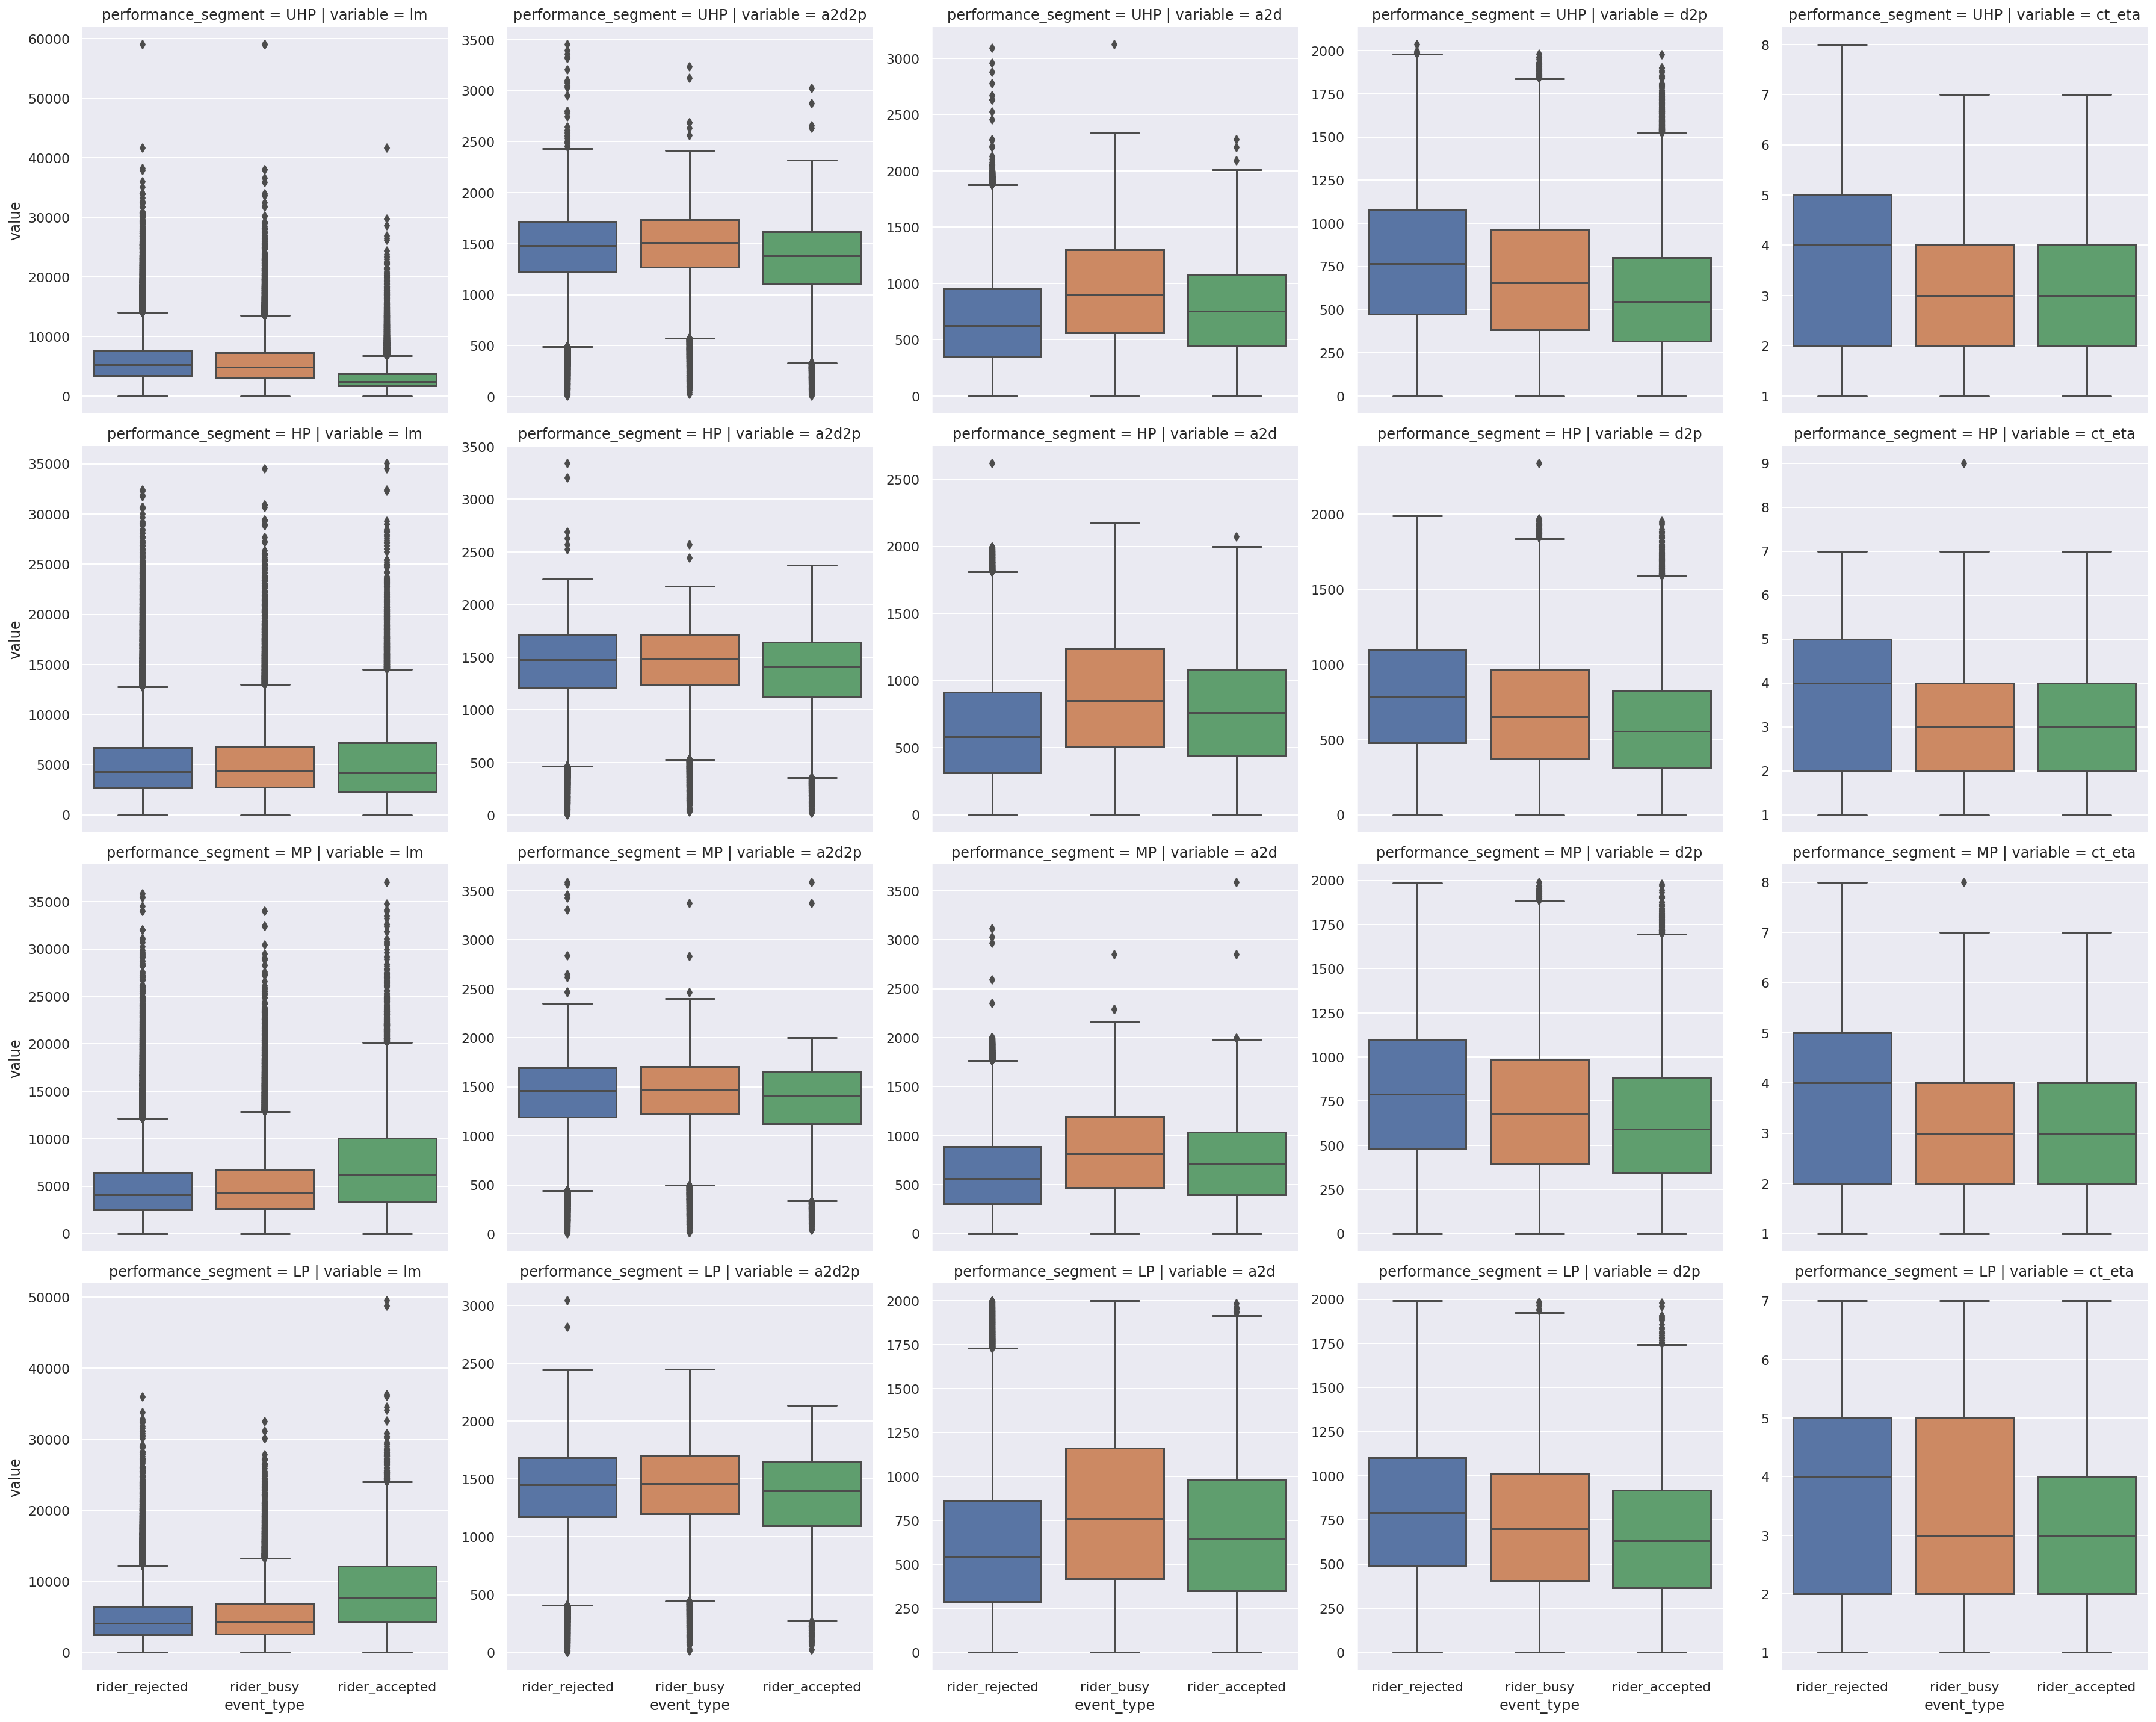

In [15]:
df_tmp_orb = df_orb[(df_orb.city_name == "Bangalore") & (df_orb.a2d > 0)]

df_tmp_orb = df_tmp_orb.drop(['ct_lm','order_level_end_state_2','consistency','time_period'], axis=1)
df_tmp_orb = df_tmp_orb[['city_name','event_type', 'performance_segment', 'lm', 'a2d2p','a2d','d2p','ct_eta']]

print(
    df_tmp_orb.pivot_table(
        index="performance_segment", columns="event_type", aggfunc="count"
    )["lm"]
)

df_tmp_orb_melt = df_tmp_orb.iloc[:, 1:].melt(
    id_vars=["event_type", "performance_segment"]
)

sns.catplot(
    data=df_tmp_orb_melt,
    col="variable",
    x="event_type",
    y="value",
    row="performance_segment",
    kind="box",
    sharey=False,
)





In [ ]:
df_tmp_orb.a2d2p

order_level_end_state_2  Net_Orders  OCARA_CC  OCARA_RC  others
performance_segment                                            
HP                             5971      2524      1149      62
LP                             1333       871       754      20
MP                             4091      2012      1442      44
UHP                            9195      3249      1118      37


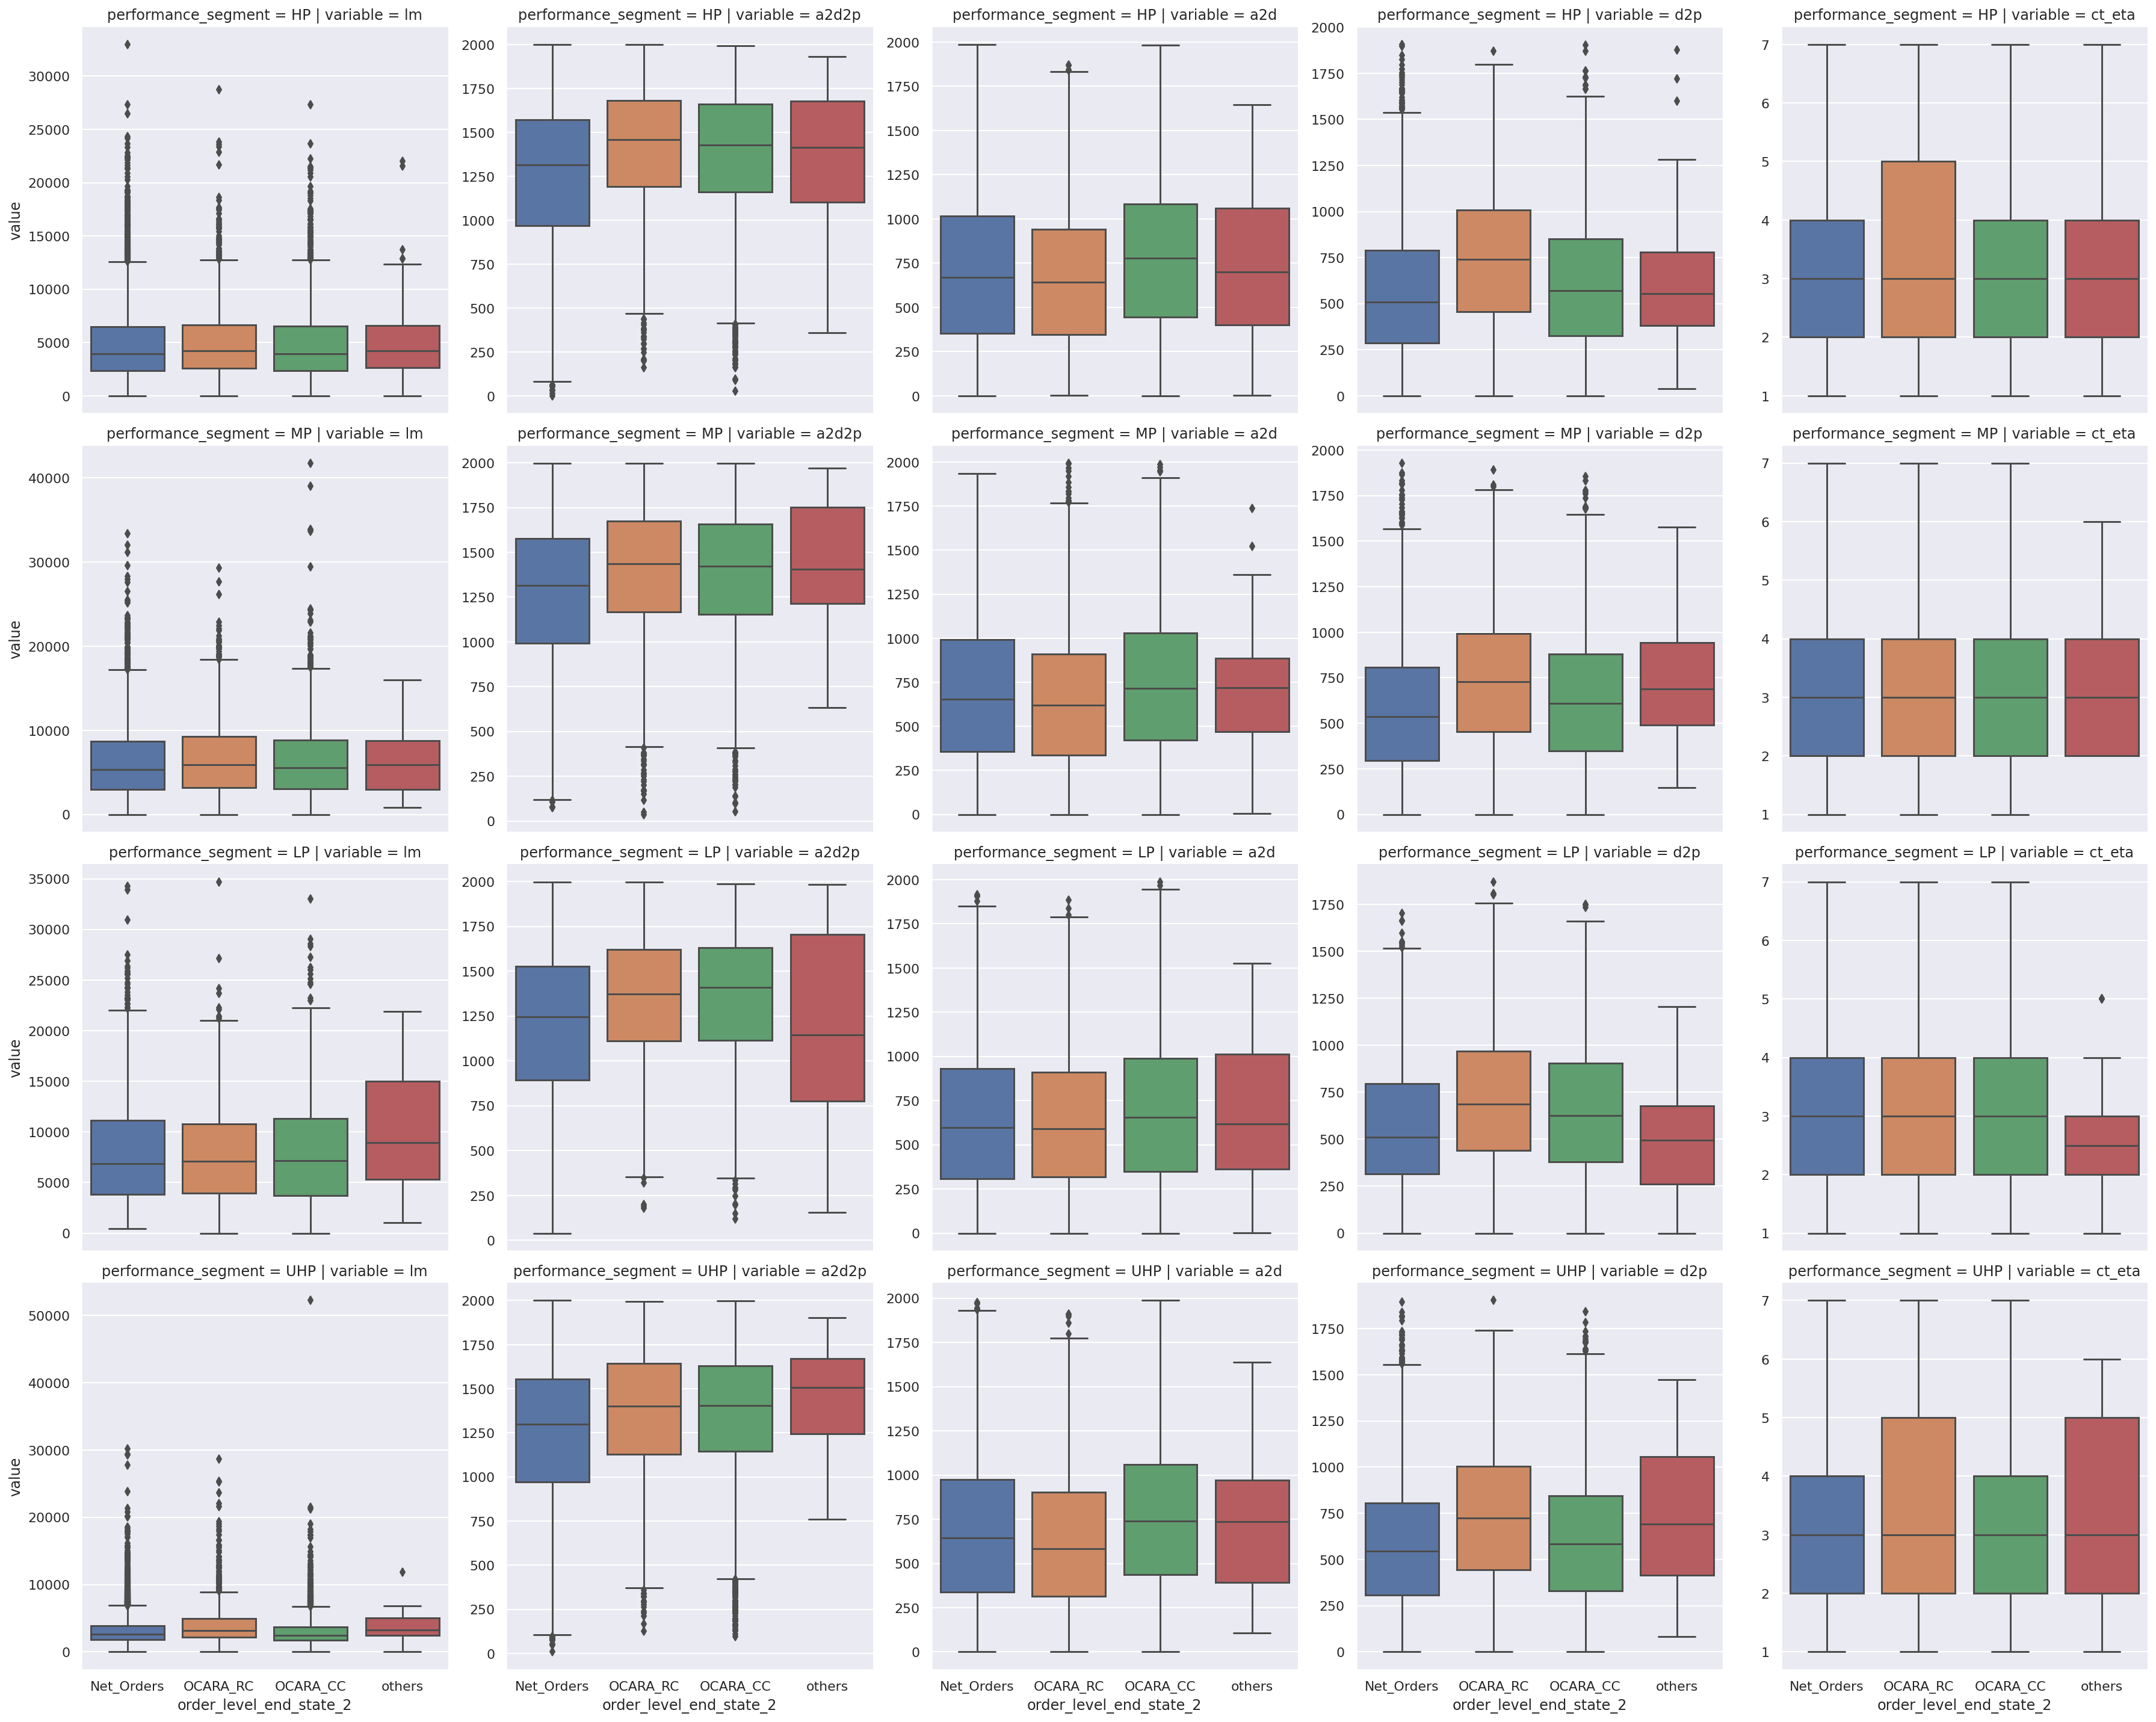

In [44]:
df_tmp_orb = df_orb[(df_orb.city_name == "Bangalore") & (df_orb.event_type =='rider_accepted') & (df_orb.a2d > 0)]

df_tmp_orb = df_tmp_orb.drop(['ct_lm','event_type','consistency','time_period'], axis=1)
df_tmp_orb = df_tmp_orb[['city_name','order_level_end_state_2', 'performance_segment', 'lm', 'a2d2p','a2d','d2p','ct_eta']]

print(
    df_tmp_orb.pivot_table(
        index="performance_segment", columns="order_level_end_state_2", aggfunc="count"
    )["lm"]
)

df_tmp_orb_melt = df_tmp_orb.iloc[:, 1:].melt(
    id_vars=["order_level_end_state_2", "performance_segment"]
)

sns.catplot(
    data=df_tmp_orb_melt,
    col="variable",
    x="order_level_end_state_2",
    y="value",
    row="performance_segment",
    kind="box",
    sharey=False,
)




event_type           rider_accepted  rider_busy  rider_rejected
performance_segment                                            
HP                             4931       10426           28798
LP                             1366        7165           24770
MP                             3972       11676           37441
UHP                            6375       11118           38105


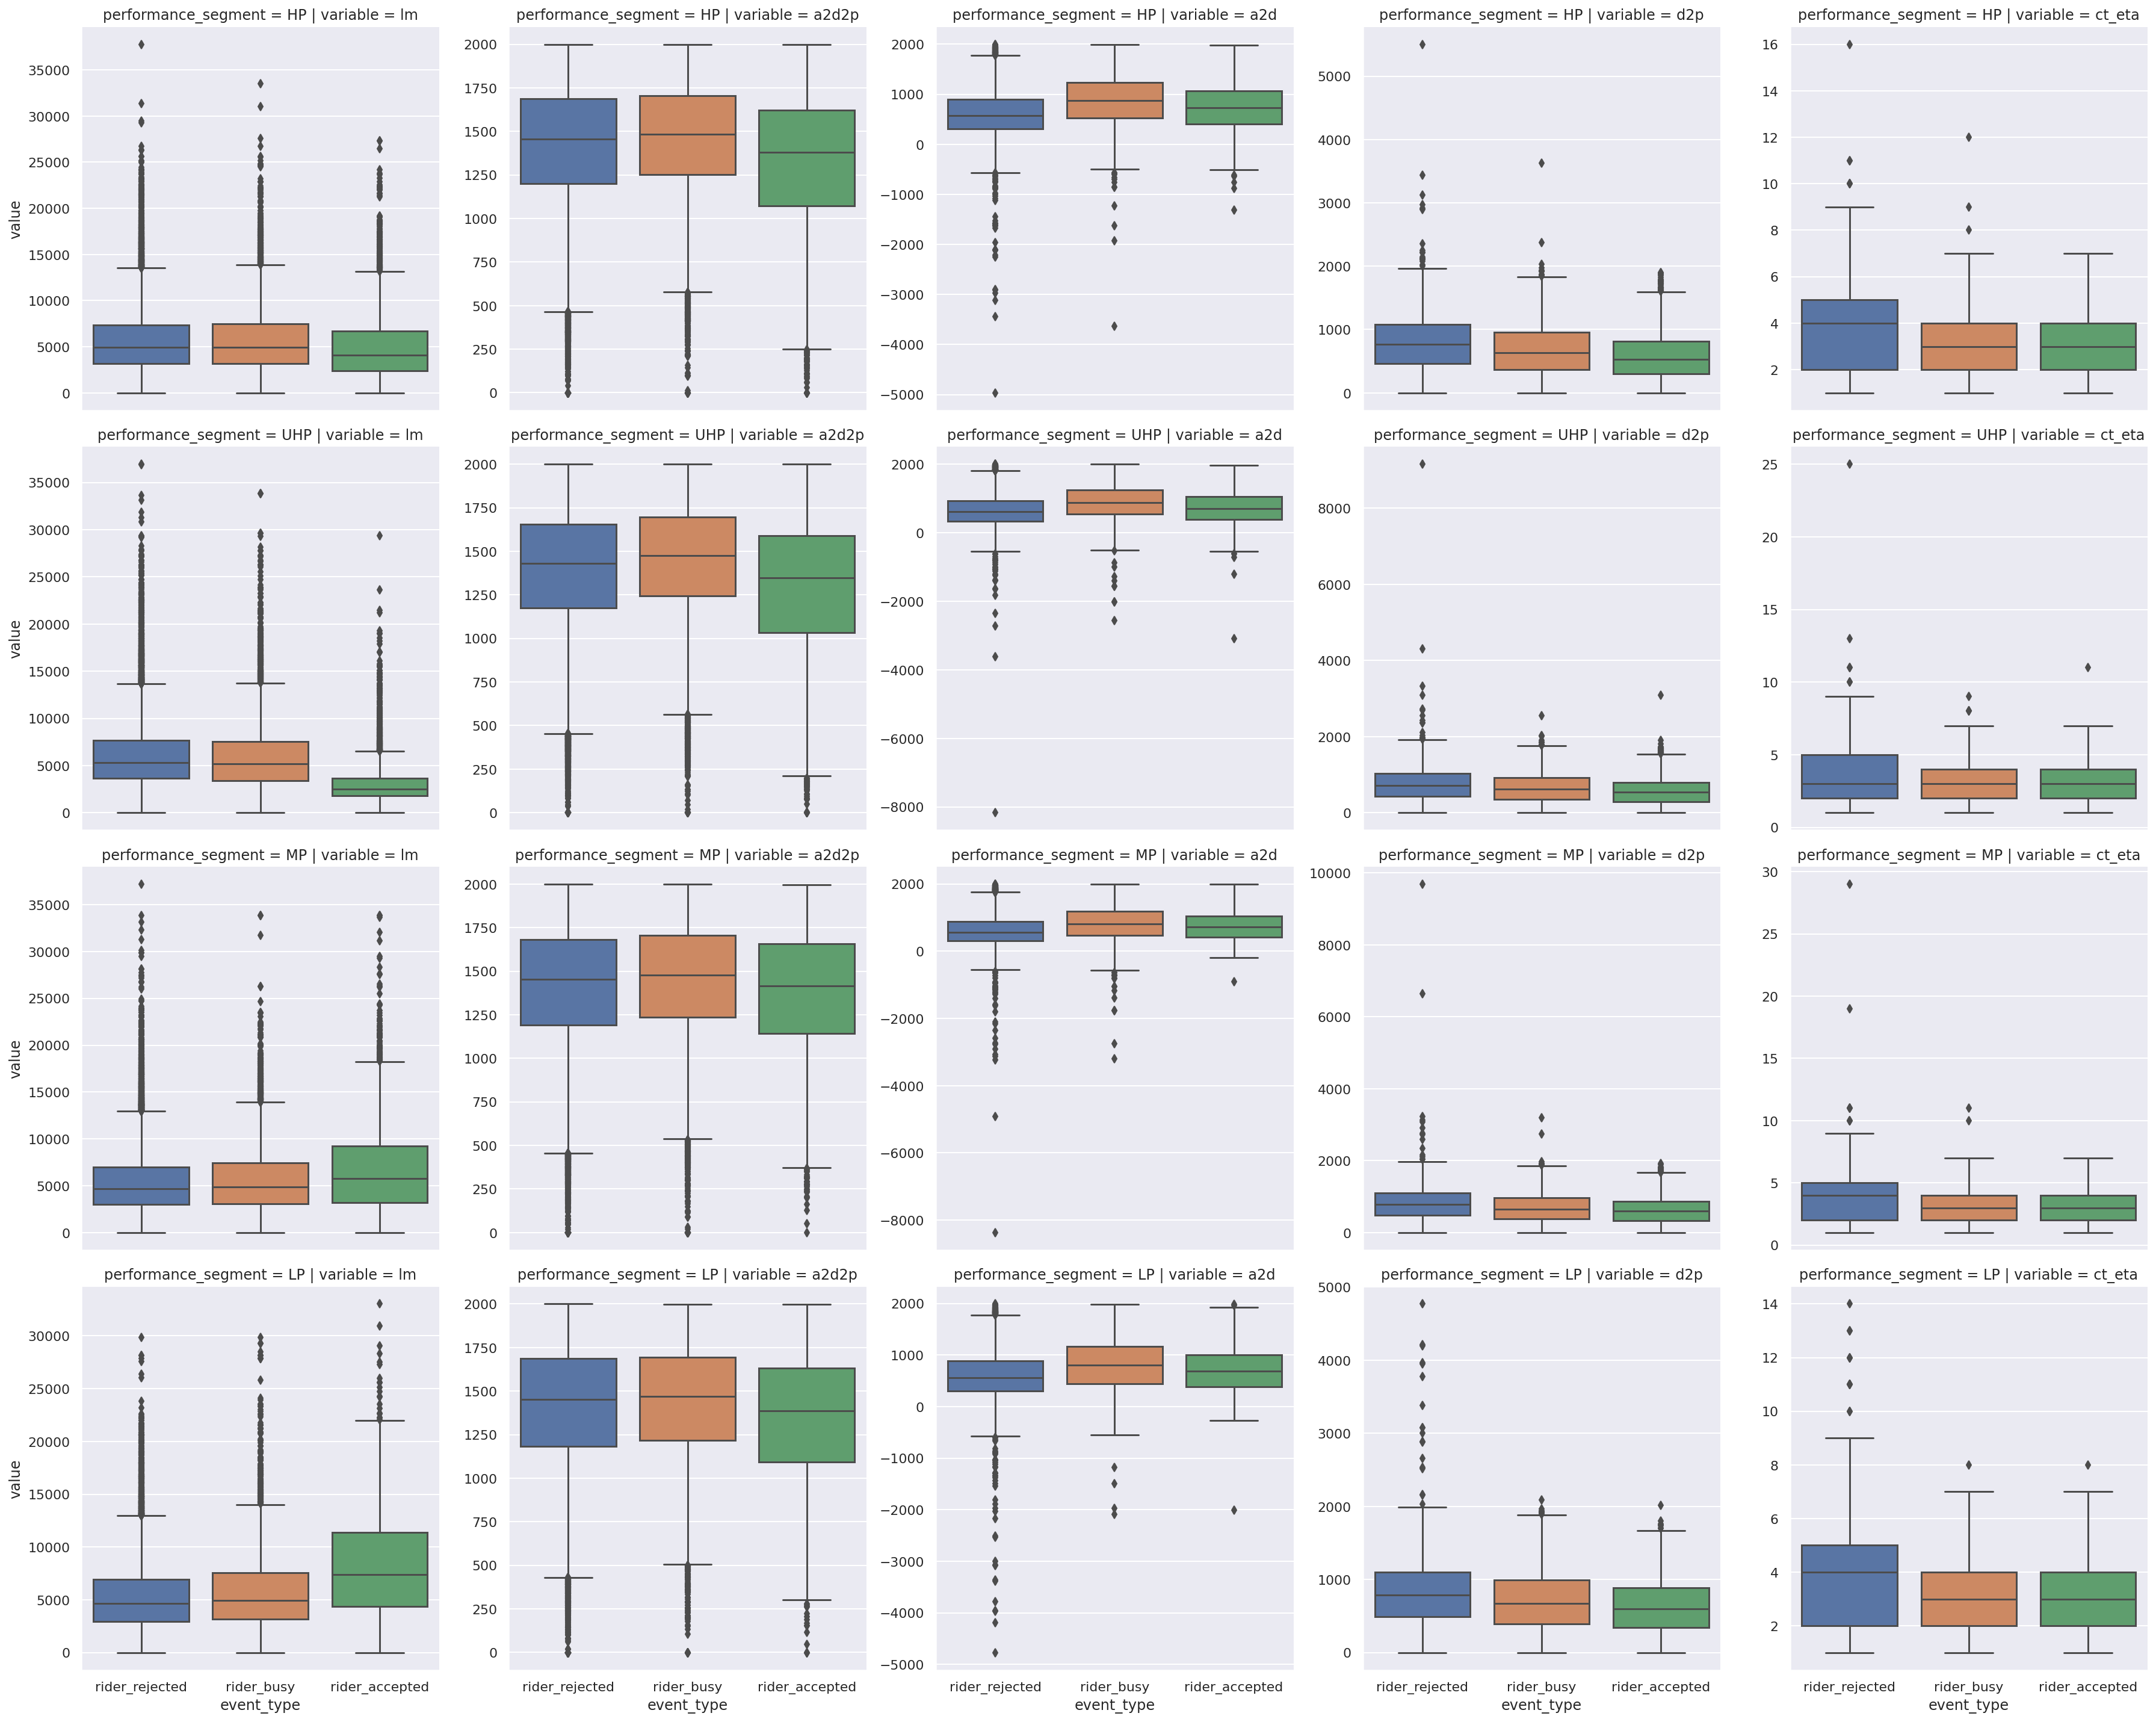

In [38]:
df_tmp_orb = df_orb[(df_orb.city_name == "Bangalore") & (df_orb.time_period == "evening_peak")]

df_tmp_orb = df_tmp_orb.drop(['ct_lm','order_level_end_state_2','consistency','time_period'], axis=1)
df_tmp_orb = df_tmp_orb[['city_name','event_type', 'performance_segment', 'lm', 'a2d2p','a2d','d2p','ct_eta']]

print(
    df_tmp_orb.pivot_table(
        index="performance_segment", columns="event_type", aggfunc="count"
    )["lm"]
)

df_tmp_orb_melt = df_tmp_orb.iloc[:, 1:].melt(
    id_vars=["event_type", "performance_segment"]
)

sns.catplot(
    data=df_tmp_orb_melt,
    col="variable",
    x="event_type",
    y="value",
    row="performance_segment",
    kind="box",
    sharey=False,
)



